### Implementazione di un modello basato su un'architettura **encoder/decoder** in grado di segmentare l'immagine riconoscendo un animale domestico raffigurato all'interno.
    
La **Segmentazione di Immagini** è il processo, in computer-vision, di divisione di un'immagine in diverse zone (segmenti, gruppi di pixel) con lo scopo di modificare la rappresentazione di un'immagine in qualcosa di più significativo o facilmente analizzabile.    

-----

In questa esercitazione implementeremo un processo di image-segmentation sfruttando un modello di rete 
neurale artificiale che sfrutta tecniche di deep-learning e un'architettura convolutiva.     
    
*(**nb**: Nelle celle troverete alcune parti da completare, identificate da ***, in modo da rendere il notebook funzionante.
Il notebook è riportato già eseguito per facilitare il completamento del codice sorgente. Diversi commenti sparsi nelle celle
spiegano il funzionamento del modello proposto e le tecniche utilizzate.)*
    
-----
    
L'architettura utilizzata unisce alla struttura encoder/decoder le **skip-connection** tipiche dell'architettura convolutiva **U-Net**, in modo da sfruttare il riconoscimento di caratteristiche sempre più dettagliate / rilevanti che avviene di layer in layer nella parte di encoder, per ricostruire al meglio la mappa di segmentazione in output alla parte di decoder.    
Per velocizzare il processo di addestramento, si è sfruttata la tecnica del **transfer-learning**, utilizzando un modello pre-addestrato come encoder, in particolare la rete **MobileNetV2**; i layer finali usati in questo modello per classificare non vengono considerati e l'output relativo alle feature estratte è posto in input alla parte di decoder, che ha una struttura analoga all'encoder ma ribaltata, struttura costruita così per facilitare la ricostruzione da singole feature estratte di una mappa di segmentazione.
    
Al fine di permettere una generalizzazione migliore del modello (nella parte finale di questo script verrà testato il modello su immagini diverse da quelle presenti nel dataset di addestramento e nel dataset usato per la validazione), sono state applicate delle tecniche di **data-augmentation** che permettono di modificare ogni singolo esempio di input con delle trasformazioni completamente casuali sulle relative immagini, fornendo al modello potenzialmente infiniti esempi su cui addestrarsi (o meglio, potenzialmente infinte variazioni del dataset di addestramento).    

In [53]:
# importazione librerie necessarie

import matplotlib.pyplot as plt
import cv2  # pip install opencv-python
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np

In [54]:
# recupero del dataset "Oxford-IIIT Pets Dataset"
# mette a disposizione delle tri-map, utili per
# l'addestramento di un modello in grado di
# segmentare le immagini di input.
#
# il dataset è formato da immagini di 37 razze
# di animali domestici, con 200 immagini per
# razza. Con ogni esempio è fornita la
# corrispondente etichetta e la maschera.
#
# Ad ogni pixel delle immagini viene assegnata
# una delle tre categorie:
#  1: animale
#  2: confine
#  3: sfondo

dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

In [55]:
# visualizzazione informazioni
# sul dataset

***

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/3.2.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_path='/Users/giumast/tensorflow_datasets/oxford_iiit_pet/3.2.0',
    download_size=773.52 MiB,
    dataset_size=774.69 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=tf.uint8),
        'species': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    spli

In [56]:
# recupero del dataset
# e applicazione di resize + normalizzazione

def normalizza(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / ***
    input_mask -= 1
    return input_image, input_mask

def carica_esempio(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))
    input_image, input_mask = normalizza(***)
    return input_image, input_mask

ds_train = dataset['train'].map(***, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = dataset['test'].map(***, num_parallel_calls=tf.data.AUTOTUNE)

In [57]:
# definizione di una classe per applicare tecniche di
# data-augmentation sul dataset in modo automatico
# durante l'addestramento

class DataAugmentation(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    # facendo usare lo stesso seed ad entrambe, verranno
    # applicate le stesse trasformazioni ad immagine e maschera
    self.augment_inputs_flip = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
    self.augment_labels_flip = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)

    self.augment_inputs_rotation = tf.keras.layers.RandomRotation(factor=(-0.05, 0.05), seed=seed)
    self.augment_labels_rotation = tf.keras.layers.RandomRotation(factor=(-0.05, 0.05), seed=seed)
    
  def call(self, inputs, labels):
    inputs = self.augment_inputs_flip(***)
    labels = self.augment_labels_flip(***)

    inputs = self.augment_inputs_rotation(***)
    labels = self.augment_labels_rotation(***)
    
    return inputs, labels

In [58]:
# costruzione della pipeline di input
# per l'addestramento

BATCH_SIZE = 4
BUFFER_SIZE = 1024

ds_train_batched = (
    ds_train
    .shuffle(***)
    .batch(***)
    .cache()
    .repeat()
    .map(DataAugmentation())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

ds_test_batched = ds_test.batch(BATCH_SIZE)

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


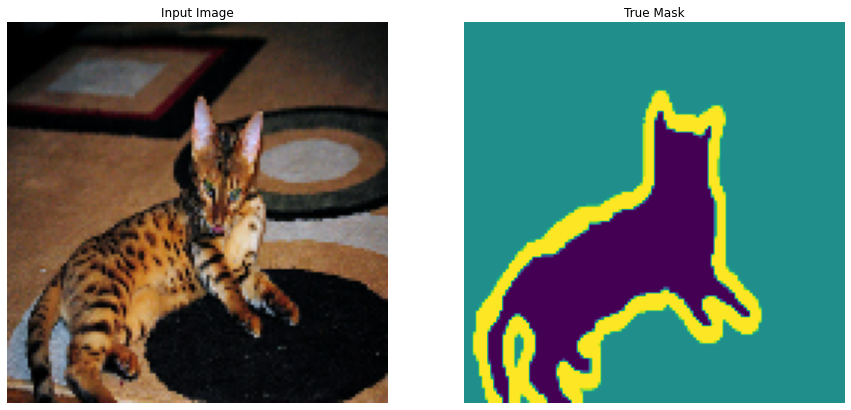

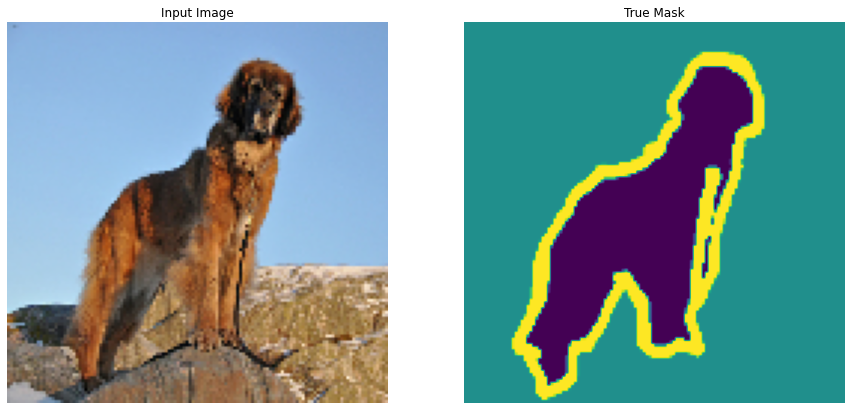

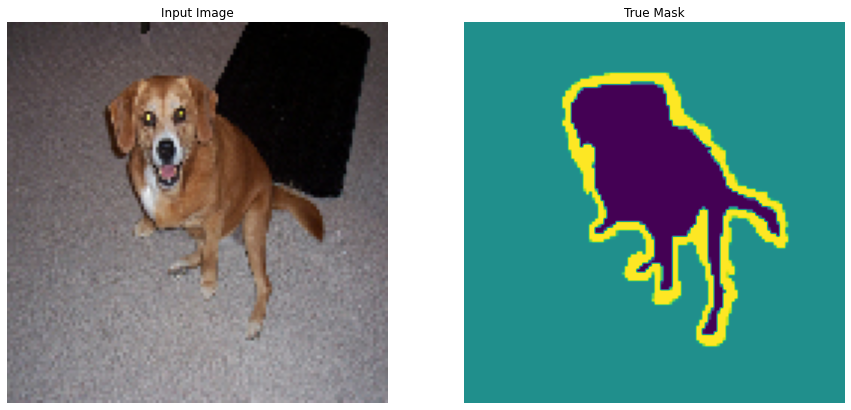

2022-03-08 19:23:26.111039: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [59]:
# visualizzazione di tre esempi

def visualizza(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[***])
        plt.imshow(tf.keras.utils.array_to_img(display_list[***]))
        plt.axis('off')
    plt.show()

for images, masks in ds_train_batched.take(3):  # recupero tre batch
    sample_image, sample_mask = images[0], masks[0]  # recupero il primo esempio del batch attuale
    visualizza([sample_image, sample_mask])

In [60]:
# recupero del modello standard MobileNetV2 pre-addestrato
# usato poi come encoder nel modello finale
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

In [61]:
# recupero dell'output di alcuni layer del modello MobileNetV2

layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  #  8x8
    'block_16_project',      #  4x4
]

base_model_outputs = [base_model.get_layer(name).output for name in ***]

In [62]:
# creazione del blocco encoder

encoder = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)
encoder.trainable = False

In [63]:
# creazione del blocco di decoder
# implementato come una serie di layer
# di up-sampling
# ogni "upsample" è un modello sequenziale
# composto da un layer di de-convoluzione
# (Conv2DTranspose) con dropout al 50%
# con funzione di attivazione swish

def upsample(filters, kernel):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv2DTranspose(filters, kernel, strides=2, padding='same', use_bias=False))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Activation('swish'))
    return model

decoder = [
    upsample(512, 3),  #  4x4  ->  8x8
    upsample(256, 3),  #  8x8  -> 16x16
    upsample(128, 3),  # 16x16 -> 32x32
    upsample(64, 3),   # 32x32 -> 64x64
]

In [64]:
# definizione del modello U-Net utilizzato

def unet_model(output_channels:int):
    inputs = tf.keras.layers.Input(shape=[128, 128, 3])

    # down-sampling iniziale (encoder)
    skips = encoder(inputs)
    for s in skips:
        print(f"Plain -> {s.get_shape()}")
    x = skips[-1]
    skips = reversed(skips[:-1])
    for s in skips:
        print(f"Reversed -> {s.get_shape()}")

    # up-sampling (decoder) e associazione delle
    # skip-connections
    for up, skip in zip(decoder, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        # print("Concatenation between {x.name} and {skip.name}")
        x = concat([x, skip])

    # layer finale del modello che restituisce
    # un'immagine di dimensioni uguali all'immagine
    # di input, i cui pixel hanno valore 0, 1 o 2
    # in base alla classe di appartenenza (animale,
    # confine, non animale)
    last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,
      padding='same')  # 64x64 -> 128x128
    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [65]:
# creazione e compilazione del modello

OUTPUT_CLASSES = ***

model = unet_model(output_channels=OUTPUT_CLASSES)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),  # problema multiclasse -> animale, confine,
                                                                           #                         non animale
    metrics=['accuracy']
)

Plain -> (None, 64, 64, 96)
Plain -> (None, 32, 32, 144)
Plain -> (None, 16, 16, 192)
Plain -> (None, 8, 8, 576)
Plain -> (None, 4, 4, 320)
Reversed -> (None, 8, 8, 576)
Reversed -> (None, 16, 16, 192)
Reversed -> (None, 32, 32, 144)
Reversed -> (None, 64, 64, 96)


In [14]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 model (Functional)             [(None, 64, 64, 96)  1841984     ['input_2[0][0]']                
                                , (None, 32, 32, 14                                               
                                4),                                                               
                                 (None, 16, 16, 192                                               
                                ),                                                          

In [16]:
def crea_maschera(pred_mask):
    # la label assegnata ad un pixel è quella corrispondente
    # al canale colore con il valore più grande
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]


# definizione di un metodo per visualizzare le predizioni del modello

def visualizza_predizioni(num=1):
    visualizza([sample_image, sample_mask, crea_maschera(model.predict(sample_image[tf.newaxis, ...]))])

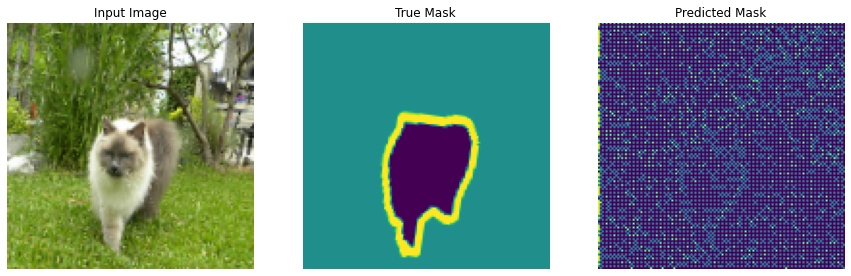

In [17]:
# visualizzazione delle predizioni
# chiamando il modello non ancora addestrato

***

In [18]:
# creazione di un callback per visualizzare come migliora
# il modello durante l'addestramento ogni 10 epoche

class TestCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if epoch % *** == 0 and epoch > 0:
            print ('\n\nPredizione epoca {}\n'.format(epoch + 1))
            visualizza_predizioni()
            print('\n', '-' * 100, '\n')

Epoch 1/30
920/920 [==============================] - 29s 29ms/step - loss: 0.3960 - accuracy: 0.8043 - val_loss: 0.3663 - val_accuracy: 0.8525
Epoch 2/30
920/920 [==============================] - 26s 28ms/step - loss: 0.3186 - accuracy: 0.8350 - val_loss: 0.3409 - val_accuracy: 0.8640
Epoch 3/30
920/920 [==============================] - 26s 28ms/step - loss: 0.3060 - accuracy: 0.8397 - val_loss: 0.3102 - val_accuracy: 0.8779
Epoch 4/30
920/920 [==============================] - 26s 28ms/step - loss: 0.2985 - accuracy: 0.8426 - val_loss: 0.3445 - val_accuracy: 0.8707
Epoch 5/30
920/920 [==============================] - 26s 28ms/step - loss: 0.2944 - accuracy: 0.8440 - val_loss: 0.3087 - val_accuracy: 0.8748
Epoch 6/30
920/920 [==============================] - 26s 28ms/step - loss: 0.2880 - accuracy: 0.8465 - val_loss: 0.3207 - val_accuracy: 0.8784
Epoch 7/30
920/920 [==============================] - 27s 29ms/step - loss: 0.2850 - accuracy: 0.8475 - val_loss: 0.3328 - val_accuracy:

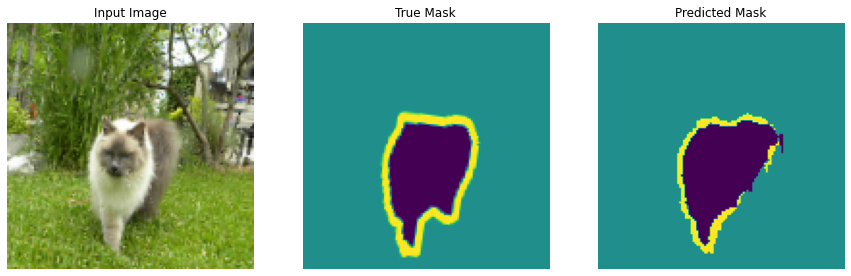


 ---------------------------------------------------------------------------------------------------- 

920/920 [==============================] - 28s 30ms/step - loss: 0.2743 - accuracy: 0.8513 - val_loss: 0.3352 - val_accuracy: 0.8740
Epoch 12/30
920/920 [==============================] - 28s 30ms/step - loss: 0.2720 - accuracy: 0.8523 - val_loss: 0.3500 - val_accuracy: 0.8757
Epoch 13/30
920/920 [==============================] - 29s 31ms/step - loss: 0.2703 - accuracy: 0.8527 - val_loss: 0.3682 - val_accuracy: 0.8700
Epoch 14/30
920/920 [==============================] - 29s 32ms/step - loss: 0.2693 - accuracy: 0.8532 - val_loss: 0.3416 - val_accuracy: 0.8731
Epoch 15/30
920/920 [==============================] - 30s 32ms/step - loss: 0.2671 - accuracy: 0.8540 - val_loss: 0.3565 - val_accuracy: 0.8767
Epoch 16/30
920/920 [==============================] - 29s 32ms/step - loss: 0.2665 - accuracy: 0.8544 - val_loss: 0.3616 - val_accuracy: 0.8753
Epoch 17/30
920/920 [================

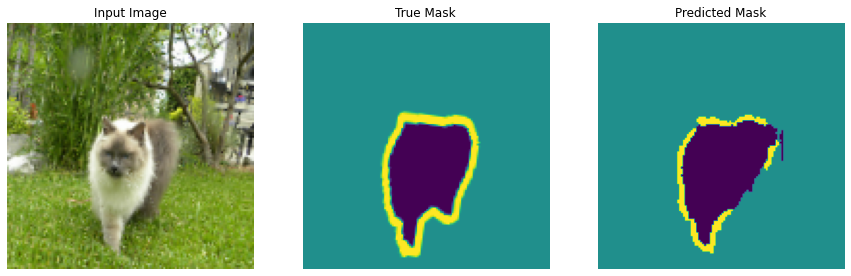


 ---------------------------------------------------------------------------------------------------- 

920/920 [==============================] - 31s 34ms/step - loss: 0.2578 - accuracy: 0.8571 - val_loss: 0.3669 - val_accuracy: 0.8736
Epoch 22/30
920/920 [==============================] - 29s 32ms/step - loss: 0.2599 - accuracy: 0.8563 - val_loss: 0.3750 - val_accuracy: 0.8705
Epoch 23/30
920/920 [==============================] - 29s 32ms/step - loss: 0.2572 - accuracy: 0.8574 - val_loss: 0.3444 - val_accuracy: 0.8778
Epoch 24/30
920/920 [==============================] - 30s 32ms/step - loss: 0.2570 - accuracy: 0.8575 - val_loss: 0.3512 - val_accuracy: 0.8765
Epoch 25/30
920/920 [==============================] - 31s 34ms/step - loss: 0.2552 - accuracy: 0.8581 - val_loss: 0.3367 - val_accuracy: 0.8761
Epoch 26/30
920/920 [==============================] - 29s 32ms/step - loss: 0.2557 - accuracy: 0.8576 - val_loss: 0.3830 - val_accuracy: 0.8679
Epoch 27/30
920/920 [================

In [19]:
# configurazione ultimi iper-parametri

STEP_PER_EPOCA = info.splits['train'].num_examples // ***
EPOCHE = 30
STEP_DI_VALIDAZIONE = ***


# addestramento del modello

model_history = model.fit(
    ds_train_batched,
    epochs=EPOCHE,
    steps_per_epoch=***,
    validation_steps=***,
    validation_data=ds_test_batched,
    callbacks=[TestCallback()]
)

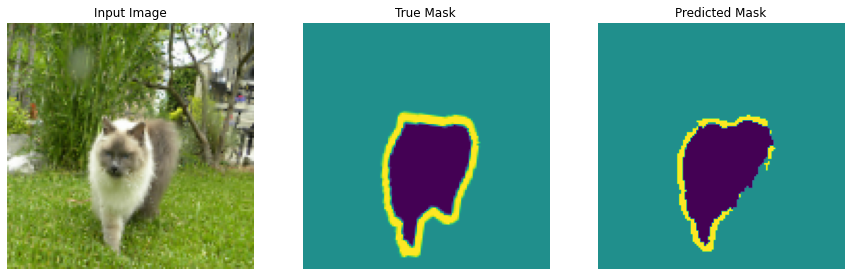

In [20]:
# visualizzazione predizione dopo l'addestramento

visualizza_predizioni()

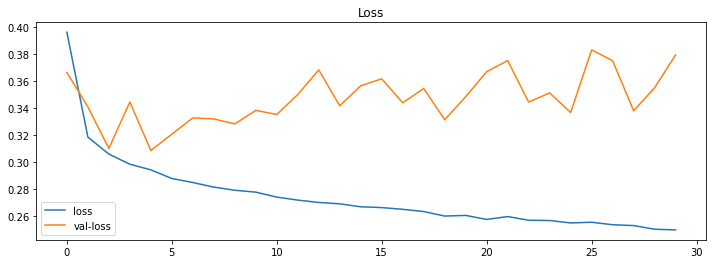

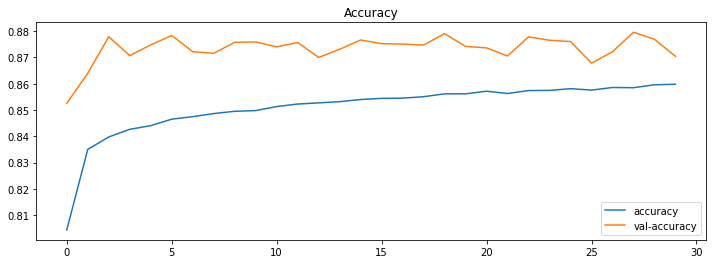

In [21]:
# visualizzazione andamento addestramento

plt.figure(figsize=(12,4))
plt.title('Loss')
plt.plot(***, label='loss')
plt.plot(***, label='val-loss')
plt.legend()
plt.show()

plt.figure(figsize=(12,4))
plt.title('Accuracy')
plt.plot(***, label='accuracy')
plt.plot(***, label='val-accuracy')
plt.legend()
plt.show()

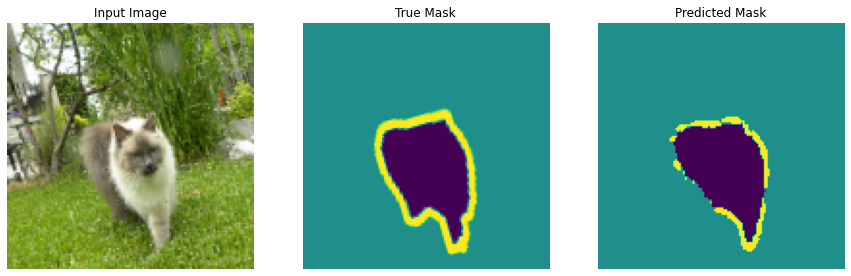

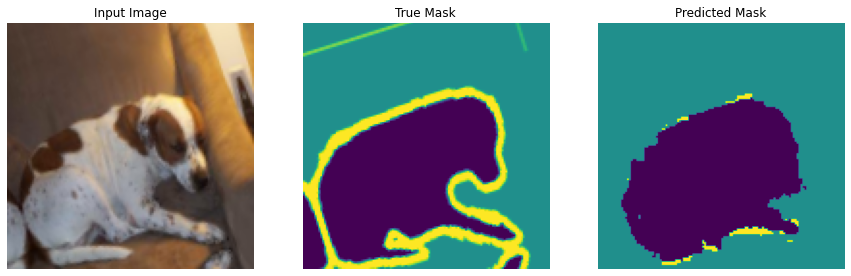

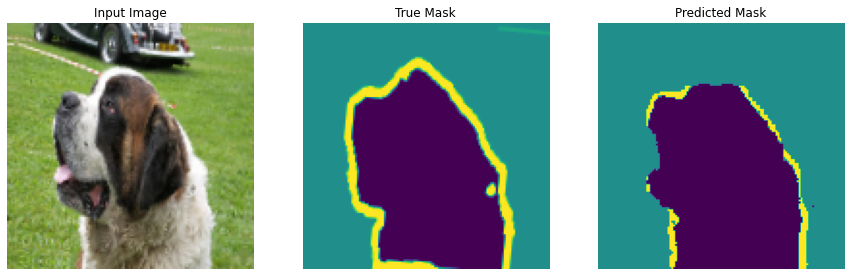

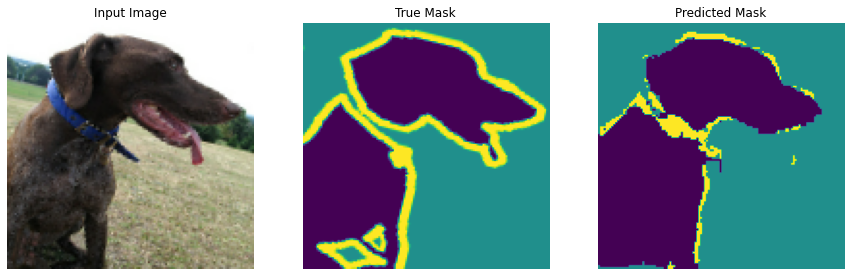

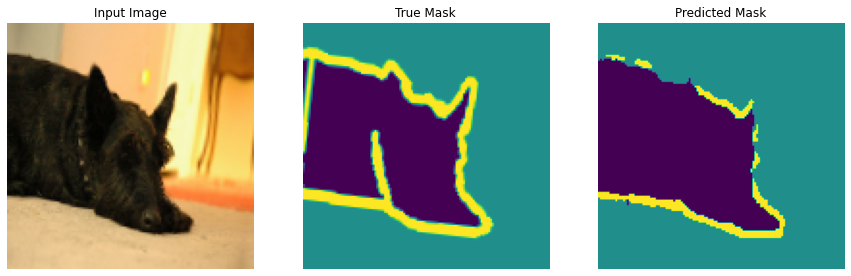

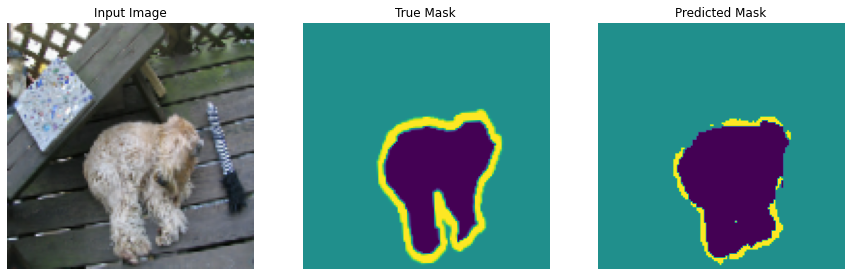

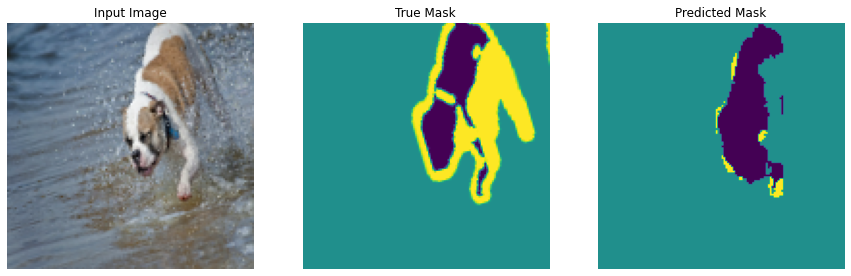

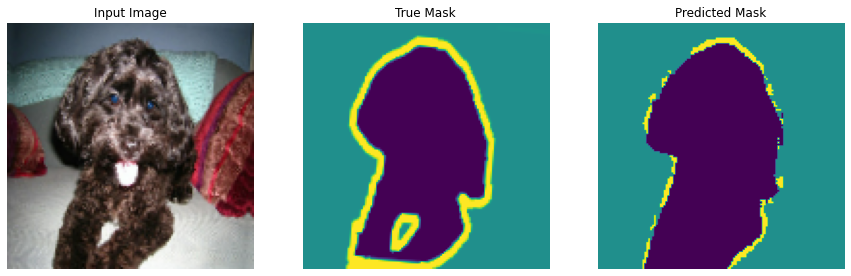

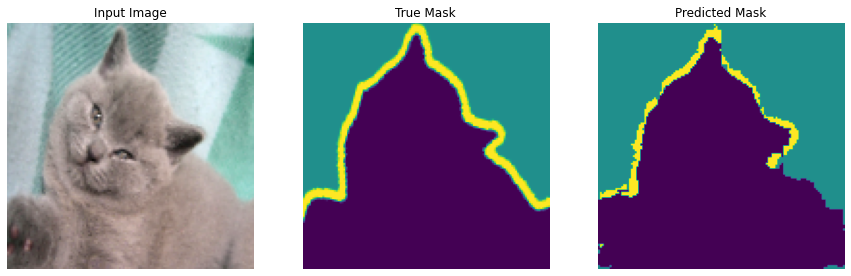

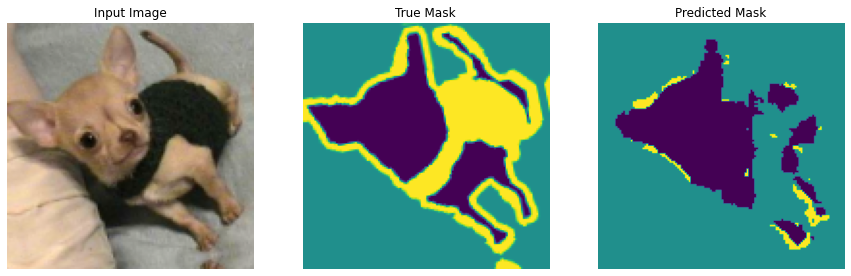

In [22]:
# previsioni su nuovi esempi dal dataset di test

for images, masks in ds_train_batched.take(10):
    sample_image, sample_mask = images[0], masks[0]
    visualizza_predizioni()

In [23]:
# test su nuove immagini
# recuperate da internet 
# (non dal dataset originale)

def predizione_nuove_immagini(filename):
    img = cv2.imread(filename)
    img = tf.cast(img, tf.float32) / 255.0
    img = tf.image.resize(img, (128, 128))

    fig = plt.figure(figsize=(15, 15))
    ax1 = fig.add_subplot(121)
    img = img[...,::-1]  # inversione dei canali colore per compatibilità con matplotlib
    ax1.imshow(***)
    img = img[...,::-1]
    ax1.axis('off')
    
    maschera_predetta = model.predict(np.asarray([img]))[0]
    risultato = crea_maschera([maschera_predetta])

    ax2 = fig.add_subplot(122)
    ax2.imshow(***)
    ax2.axis('off')
    
    plt.show()

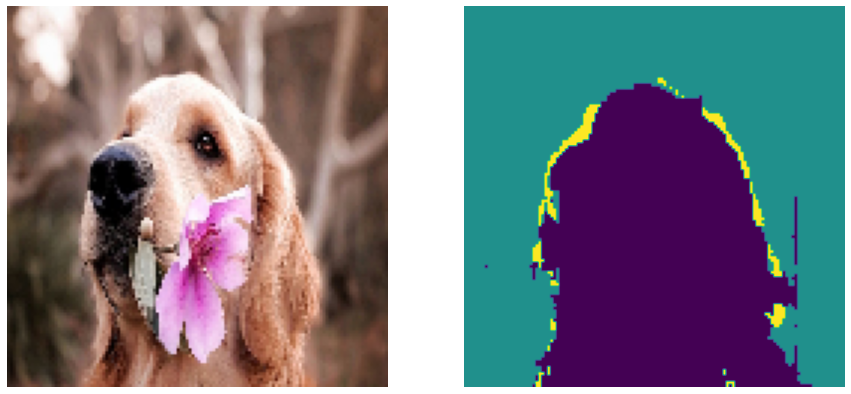

In [24]:
predizione_nuove_immagini('cane-fiore.jpg')

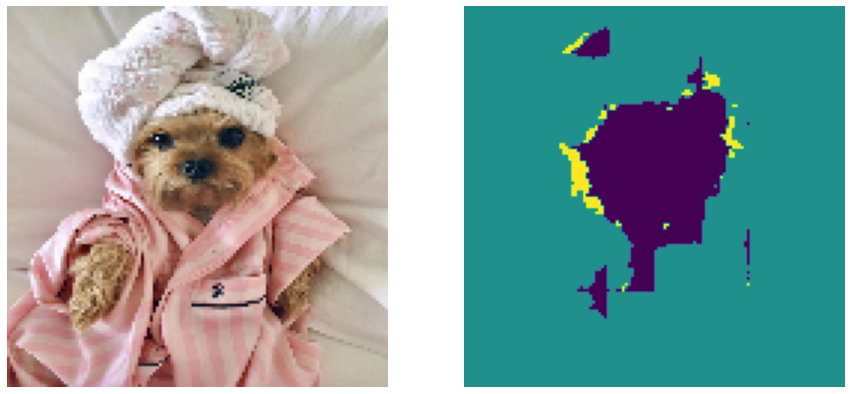

In [25]:
predizione_nuove_immagini('cane-buffo.jpg')

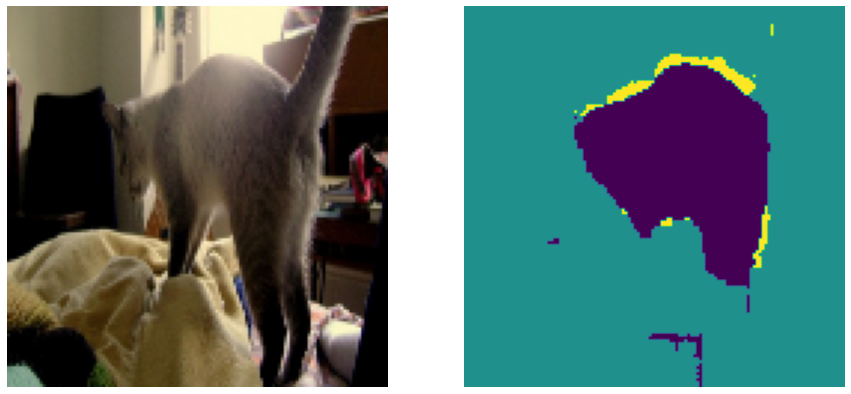

In [26]:
predizione_nuove_immagini('gatto-casa.png')

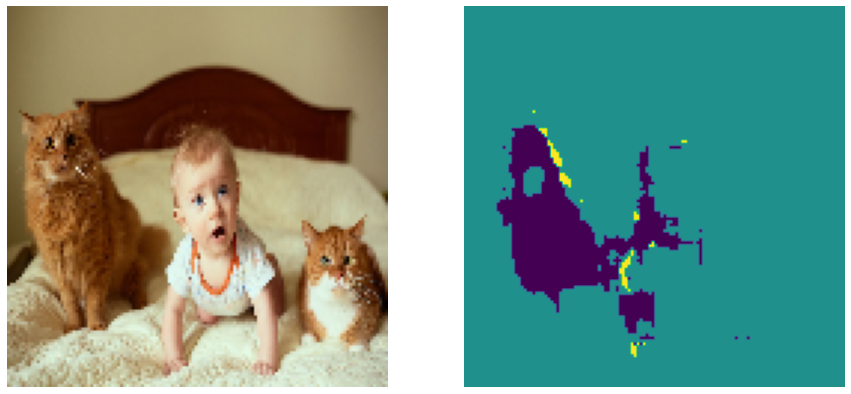

In [27]:
# test con immagini più complesse e diverse dal dataset
# di addestramento: più soggetti in un'immagine

predizione_nuove_immagini('gatti-bambino.jpg')

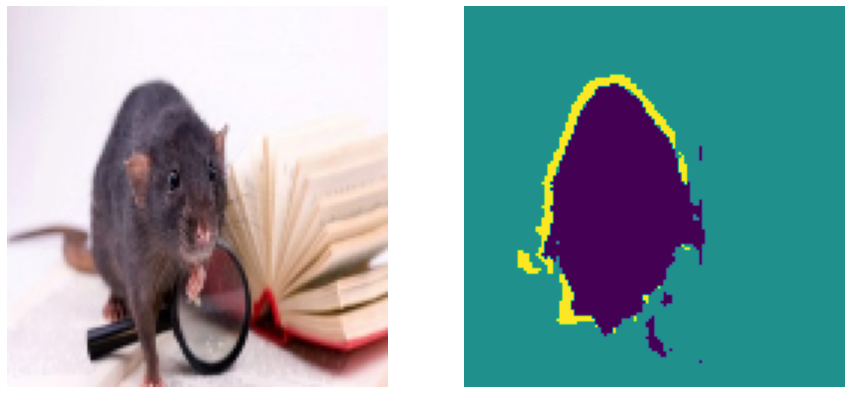

In [28]:
# test con un soggetto non presente nel dataset
# di addestramento: un topo

predizione_nuove_immagini('topo.jpg')

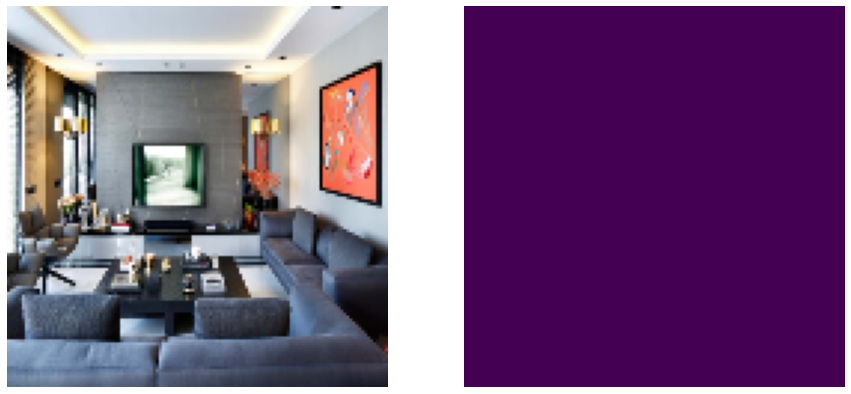

In [29]:
# test su un'immagine senza alcun animale
# domestico raffigurato

predizione_nuove_immagini('casa.jpg')